# Develop negative log-likelihood with scaled inputs

In [1]:
from __future__ import annotations

import numdifftools as nd
import numpy as np

from numpy.typing import ArrayLike
from scipy.fft import rfft, irfft, rfftfreq
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
from scipy.optimize import approx_fprime
from numpy.random import default_rng

import thztools as thz
from thztools.thztools import _tdnll_scaled as tdnll_scaled

## Simulate measurements

In [2]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
thz.global_options.sampling_time = ts
t = thz.timebase(n)
mu = thz.wave(n)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise_model = thz.NoiseModel(sigma_alpha=sigma[0], 
                             sigma_beta=sigma[1], 
                             sigma_tau=sigma[2])
noise = noise_model.noise((np.ones((m, 1)) * mu), seed=0)
x = np.array(mu + noise)
delta = np.zeros(n)
alpha = np.zeros(m - 1)
eta = np.zeros(m - 1)

logv = np.log(sigma**2)
scale_logv = 1e0 * np.ones(3)
scale_delta = 1e-0 * noise_model.amplitude(mu)
scale_alpha = 1e-4 * np.ones(m - 1)
scale_eta = 1e-3 * np.ones(m - 1)
scale_v = 1.0e-4

## Check gradient

In [3]:
_, grad_delta_tdnll = tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta / ts,
    fix_logv=True,
    fix_delta=False,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=np.ones(n),
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=1.0,
)

_, grad_delta_tdnll_scaled = tdnll_scaled(
    x,
    np.log(np.exp(logv) / scale_v) / scale_logv,
    delta / scale_delta,
    alpha,
    eta / ts,
    fix_logv=True,
    fix_delta=False,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=scale_logv,
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_delta_nd = nd.Gradient(
    lambda _delta: tdnll_scaled(
        x,
        np.log(np.exp(logv) / scale_v),
        _delta,
        alpha,
        eta / ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=np.ones(n),
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0],
    step=1e-6,
)(delta)

np.stack(
    (
        grad_delta_tdnll,
        grad_delta_tdnll_scaled / scale_v / scale_delta,
        grad_delta_nd / scale_v,
    )
).T

array([[-2.35871811e+06, -2.35871811e+06, -2.35871493e+06],
       [ 3.55032511e+05,  3.55032511e+05,  3.55031295e+05],
       [-4.67987716e+06, -4.67987716e+06, -4.67986837e+06],
       [-1.08867091e+05, -1.08867091e+05, -1.08866331e+05],
       [ 4.37387077e+06,  4.37387077e+06,  4.37386301e+06],
       [-1.20063416e+06, -1.20063416e+06, -1.20063067e+06],
       [-6.79297665e+06, -6.79297665e+06, -6.79296153e+06],
       [-4.91508770e+06, -4.91508770e+06, -4.91507677e+06],
       [ 4.20989258e+06,  4.20989258e+06,  4.20988391e+06],
       [ 8.42661030e+06,  8.42661030e+06,  8.42659379e+06],
       [ 3.15375945e+06,  3.15375945e+06,  3.15375235e+06],
       [ 3.16034805e+05,  3.16034805e+05,  3.16034728e+05],
       [ 1.59363260e+07,  1.59363260e+07,  1.59362954e+07],
       [ 1.93294918e+06,  1.93294918e+06,  1.93294583e+06],
       [ 9.75158630e+06,  9.75158630e+06,  9.75156864e+06],
       [ 4.84365400e+06,  4.84365400e+06,  4.84364447e+06],
       [ 2.95156310e+06,  2.95156310e+06

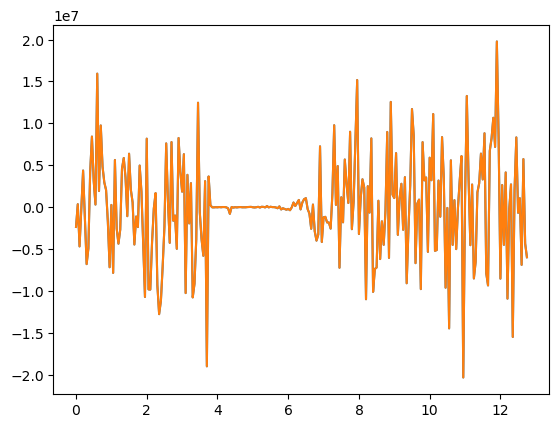

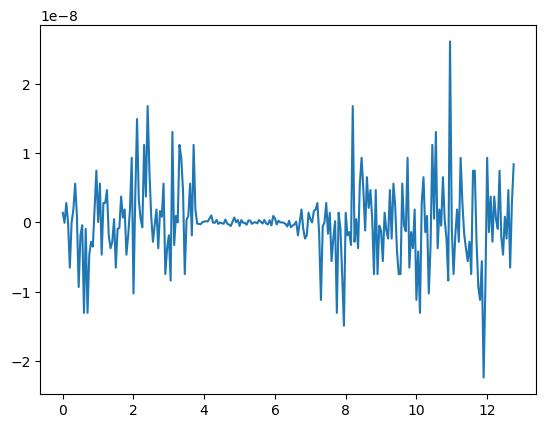

In [4]:
plt.plot(t, grad_delta_tdnll)
plt.plot(t, grad_delta_tdnll_scaled / scale_v / scale_delta)
plt.show()
plt.plot(t, grad_delta_tdnll - grad_delta_tdnll_scaled / scale_v / scale_delta)
plt.show()

In [5]:
val, grad_logv_tdnll = tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta / ts,
    fix_logv=False,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=1.0,
)

val_scaled_v, grad_logv_tdnll_scaled_v = tdnll_scaled(
    x,
    np.log(np.exp(logv) / scale_v),
    delta,
    alpha,
    eta / ts,
    fix_logv=False,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

val_scaled, grad_logv_tdnll_scaled = tdnll_scaled(
    x,
    np.log(np.exp(logv) / scale_v) / scale_logv,
    delta,
    alpha,
    eta / ts,
    fix_logv=False,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=True,
    scale_logv=scale_logv,
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_logv_nd = nd.Gradient(
    lambda _logv: tdnll_scaled(
        x,
        np.log(np.exp(_logv) / scale_v) / scale_logv,
        delta,
        alpha,
        eta / ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=scale_logv,
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0]
)(logv)

print(f"{val =}")
print(f"{val_scaled_v / scale_v =}")
print(f"{val_scaled / scale_v =}")
np.stack(
    (
        grad_logv_tdnll,
        grad_logv_tdnll_scaled_v,
        grad_logv_tdnll_scaled / scale_logv,
        grad_logv_nd,
    )
).T

val =-133806.95268556869
val_scaled_v / scale_v =-133806.95268556866
val_scaled / scale_v =-133806.95268556866


array([[-6.55555590e+03, -6.55555590e-01, -6.55555590e-01,
        -6.55555590e-01],
       [-7.31417771e+03, -7.31417771e-01, -7.31417771e-01,
        -7.31417771e-01],
       [-5.04695010e+02, -5.04695010e-02, -5.04695010e-02,
        -5.04695010e-02]])

In [6]:
_, grad_alpha_tdnll = tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta / ts,
    fix_logv=True,
    fix_delta=True,
    fix_alpha=False,
    fix_eta=True,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_alpha_nd = nd.Gradient(
    lambda _alpha: tdnll_scaled(
        x,
        logv,
        delta,
        _alpha,
        eta / ts,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0]
)(alpha)

np.stack((grad_alpha_tdnll, grad_alpha_nd)).T

array([[ -480.34272322,  -480.34272324],
       [  517.90051992,   517.90051993],
       [-1517.46755076, -1517.46755077],
       [-2254.90129909, -2254.90129906],
       [ 1256.22540729,  1256.22540732],
       [-3131.50979725, -3131.50979729],
       [-1605.11920648, -1605.1192065 ],
       [  736.90955887,   736.909559  ],
       [-1009.01668927, -1009.01668942],
       [-1239.59081267, -1239.59081271],
       [ -139.52771288,  -139.52771286],
       [-1091.89366065, -1091.89366066],
       [ -894.22897085,  -894.22897091],
       [-1148.68351094, -1148.68351104],
       [ -668.84933784,  -668.84933779],
       [-2582.73606726, -2582.73606741],
       [-1072.91807681, -1072.91807687],
       [-2023.19083139, -2023.19083142],
       [  450.01976629,   450.01976625],
       [-3578.23363493, -3578.23363492],
       [ -230.3333722 ,  -230.33337221],
       [  669.3300595 ,   669.33005958],
       [-1074.94123783, -1074.94123782],
       [ -538.67097552,  -538.67097557],
       [-2110.72

In [7]:
_, grad_eta_tdnll = tdnll_scaled(
    x,
    logv,
    delta,
    alpha,
    eta / ts,
    fix_logv=True,
    fix_delta=True,
    fix_alpha=True,
    fix_eta=False,
    scale_logv=np.ones(3),
    scale_delta=scale_delta,
    scale_alpha=np.ones(m - 1),
    scale_eta=np.ones(m - 1),
    scale_v=scale_v,
)

grad_eta_nd = nd.Gradient(
    lambda _eta_scaled: tdnll_scaled(
        x,
        logv,
        delta,
        alpha,
        _eta_scaled,
        fix_logv=True,
        fix_delta=True,
        fix_alpha=True,
        fix_eta=True,
        scale_logv=np.ones(3),
        scale_delta=scale_delta,
        scale_alpha=np.ones(m - 1),
        scale_eta=np.ones(m - 1),
        scale_v=scale_v,
    )[0]
)(eta)

np.stack((grad_eta_tdnll, grad_eta_nd)).T

array([[-1908.63474864, -1908.63474853],
       [  -90.61244439,   -90.61244445],
       [-3443.32503743, -3443.32503749],
       [-2331.99279505, -2331.99279507],
       [-4689.56272025, -4689.56272041],
       [ 3079.06092552,  3079.0609255 ],
       [ 1416.54249805,  1416.54249797],
       [-1321.57562523, -1321.57562526],
       [   61.73689753,    61.73689754],
       [ 1529.3369301 ,  1529.33693007],
       [-3825.25095319, -3825.2509531 ],
       [  531.73551771,   531.73551748],
       [ 3975.30202747,  3975.30202738],
       [-2644.26089237, -2644.26089238],
       [  766.41131968,   766.41131964],
       [ 1550.66246727,  1550.66246722],
       [-4607.35970971, -4607.35970967],
       [ -583.39141471,  -583.39141479],
       [-3044.39210121, -3044.39210131],
       [  260.26576688,   260.26576675],
       [  502.60887367,   502.60887362],
       [-5884.8000285 , -5884.80002856],
       [-2596.06032595, -2596.06032589],
       [-1419.20259043, -1419.20259067],
       [ -868.59

## Estimate noise parameters with revised NLL

In [8]:
result = thz.noisefit(x.T, v0=sigma**2, dt=ts, fix_a=False, fix_eta=False)

In [9]:
print(result.diagnostic["message"])

Desired error not necessarily achieved due to precision loss.


In [10]:
var_alpha = result.noise_model.sigma_alpha**2 * m / (m - 1)
var_beta = result.noise_model.sigma_beta**2 * m / (m - 1)
var_tau = result.noise_model.sigma_tau**2 * m / (m - 1)
var_out = np.array([var_alpha, var_beta, var_tau])
var_err = result.err_var * m / (m - 1)
for val_in, val_out, err in zip(sigma**2, var_out, var_err):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g} ± {err:6.4g}")

Input:  1e-10	 Output: 9.964e-11 ± 1.345e-12
Input: 0.0001	 Output: 9.863e-05 ± 2.389e-06
Input:  1e-06	 Output: 8.849e-07 ± 5.094e-08


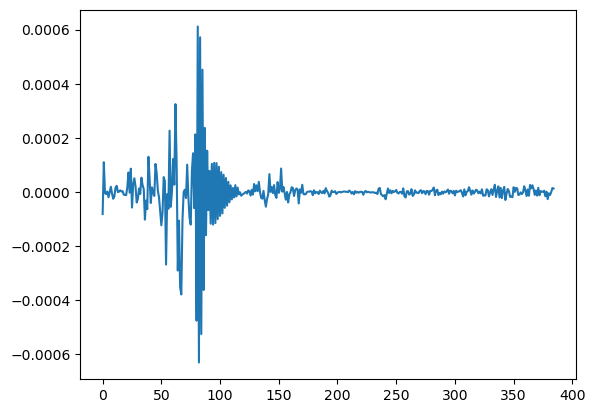

In [11]:
plt.plot(result.diagnostic["jac"])
plt.show()

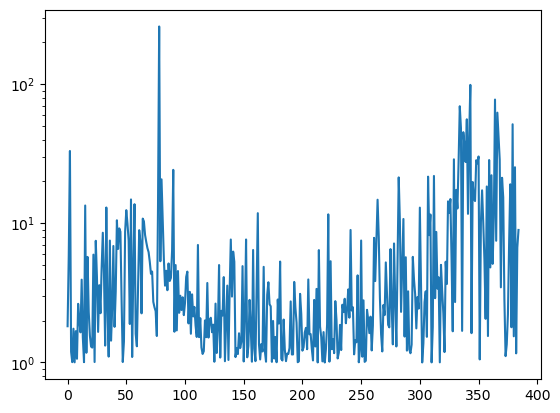

In [12]:
plt.semilogy(np.diag(result.diagnostic["hess_inv"]))
plt.show()

In [13]:
np.diag(result.diagnostic["hess_inv"][:3, :3])

array([ 1.82186727,  5.86949203, 33.13203903])

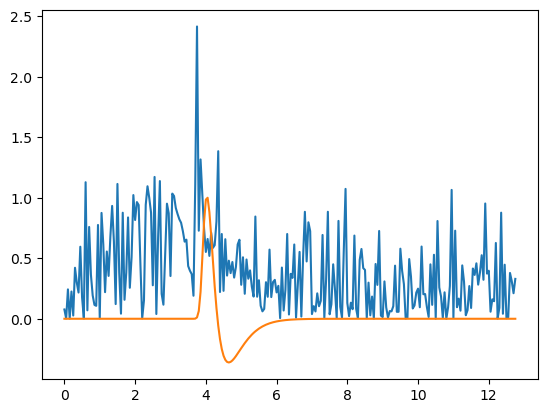

In [14]:
plt.plot(t, np.log10(np.diag(result.diagnostic["hess_inv"])[3 : 3 + n]))
plt.plot(t, mu)
plt.show()

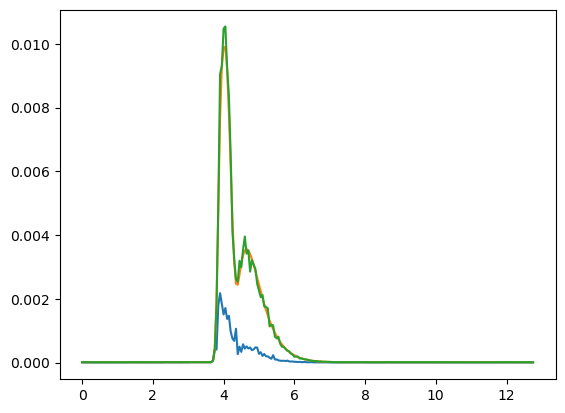

In [15]:
var_alpha = result.noise_model.sigma_alpha**2
var_beta = result.noise_model.sigma_beta**2
var_tau = result.noise_model.sigma_tau**2
noise_model_fit = thz.NoiseModel(
    sigma_alpha = result.noise_model.sigma_alpha,
    sigma_beta = result.noise_model.sigma_beta,
    sigma_tau = result.noise_model.sigma_tau
)

plt.plot(t, result.err_delta * np.sqrt(m))
plt.plot(t, noise_model_fit.amplitude(result.mu))
plt.plot(t, np.std(x, axis=0))
plt.show()

## Repeat fit with amplitudes and delays fixed

In [16]:
result = thz.noisefit(x.T, v0=sigma**2, dt=ts, fix_a=True, fix_eta=True)
print(result.diagnostic["message"])

Optimization terminated successfully.


In [17]:
var_alpha = result.noise_model.sigma_alpha**2 * m / (m - 1)
var_beta = result.noise_model.sigma_beta**2 * m / (m - 1)
var_tau = result.noise_model.sigma_tau**2 * m / (m - 1)
var_out = np.array([var_alpha, var_beta, var_tau])
var_err = result.err_var * m / (m - 1)
for val_in, val_out, err in zip(sigma**2, var_out, var_err):
    print(f"Input: {val_in:6.4g}\t Output: {val_out:6.4g} ± {err:6.4g}")

Input:  1e-10	 Output: 9.998e-11 ± 1.158e-12
Input: 0.0001	 Output: 9.819e-05 ± 2.383e-06
Input:  1e-06	 Output: 9.533e-07 ± 3.914e-08


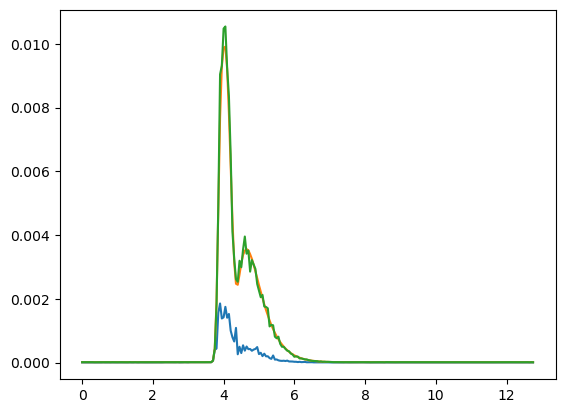

In [18]:
plt.plot(t, result.err_delta * np.sqrt(m))
plt.plot(t, noise_model_fit.amplitude(result.mu))
plt.plot(t, np.std(x, axis=0))
plt.show()